## US Option prices with Trees, Random Forests, Boosting, and Neural Nets

We try a single tree, random forests, boosting, and neural nets on the US Options price data with y = mid_price and x= (moneyness,tau, impl_volatility).

(1) mid_price = (best_bid + best_offer) / 2,

(2) moneyness = price of underlying asset / strike price,

(3) tau = time of expiry,

(4) impl_volatility = implied volatility.


Let’s do a simple train/test split and compare the methods based on rmse on the test data.

## Basic Imports and Read in the Data

We use the same data and train/test split for each method.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##sklearn model selection
from sklearn.model_selection import train_test_split

## scale the x variables when there is more than one
from sklearn.preprocessing import StandardScaler

def myrmse(y, yhat):
    return np.round(np.sqrt(np.mean((y - yhat)**2)), 3)

In [4]:
# Load CSV
df_us = pd.read_csv("/Users/judepereira/Downloads/OptionPricesUS.csv")
df_sec = pd.read_csv("/Users/judepereira/Downloads/SecurityPricesUS.csv")

# Preprocess the date columns
df_us['date'] = pd.to_datetime(df_us['date'], errors='coerce')
df_us['exdate'] = pd.to_datetime(df_us['exdate'], errors='coerce')
df_sec['date'] = pd.to_datetime(df_sec['date'], errors='coerce')

# Merge security prices into US options
df_us = df_us.merge(df_sec[['secid', 'date', 'close']], on=['secid', 'date'], how='left')
df_us = df_us.rename(columns={'close': 'underlying_price'})

# Filter and compute features
df_us = df_us.dropna(subset=['impl_volatility', 'best_bid', 'best_offer', 'underlying_price'])
df_us['tau'] = (df_us['exdate'] - df_us['date']).dt.days / 365.0
df_us = df_us[df_us['tau'] > 0]
df_us['strike_price'] = df_us['strike_price'] / 100.0
df_us['mid_price'] = (df_us['best_bid'] + df_us['best_offer']) / 2
df_us['moneyness'] = df_us['underlying_price'] / df_us['strike_price']

# Final dataset
features = df_us[['moneyness', 'tau', 'impl_volatility']]
target = df_us['mid_price']

In [6]:
# Polynomial expansion
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(features)
y = target.values

In [8]:
#train/test split

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42, test_size=0.2)

print(f'train sample size is {ytrain.shape[0]}\n')
print(f'test sample size is {ytest.shape[0]}\n')

train sample size is 15895

test sample size is 3974



## Single Tree 

Note that in sklearn.DecisionTreeRegressor, the process creates a new pruned tree rather than modifying the existing one. In scikit-learn, you can't directly prune an already fitted tree object - you need to create a new tree with the appropriate complexity parameter.

Below I fit a single tree to the data two different ways.  

To get ypredT, I set a maximum depth of 10.

To get ypredT2 I tried looping over different cost complexity pruning values to see what worked best.  This gave me a tree with 236 bottom nodes.  

In [9]:
##sklearn learners
from sklearn.tree import DecisionTreeRegressor

In [10]:
# tree with 10 bottom nodes
#tmod = DecisionTreeRegressor(max_leaf_nodes=20)
tmod = DecisionTreeRegressor(max_depth=10, min_samples_split=10)
tmod.fit(Xtrain,ytrain)
ypredT = tmod.predict(Xtest)

number of bottom  nodes:  339


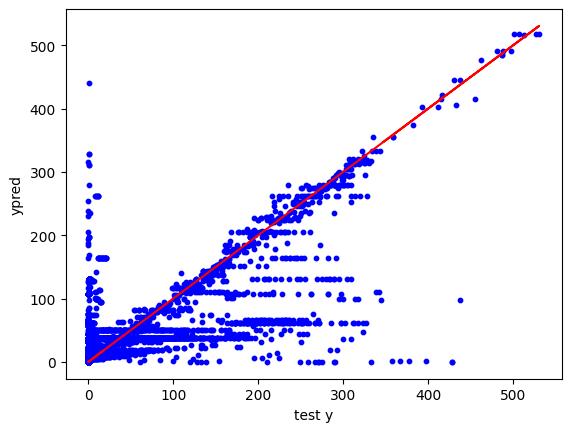

In [11]:
plt.scatter(ytest,ypredT,c='blue',s=10)
plt.xlabel('test y'); plt.ylabel('ypred')
plt.plot(y,y,c='red')
print("number of bottom  nodes: ",pd.Series(ypredT).nunique())

In [13]:
rmseT  = myrmse(ypredT,ytest)
print(f'rmse for tree is {rmseT}\n')

rmse for tree is 60.965



Now I'll try the other approach where I try a variety of alphas (the cost complexity parameter in sklearn).  


In [14]:
# Create a full tree first
#dt_regressor = DecisionTreeRegressor(random_state=42,max_leaf_nodes=100)
dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=10)
dt_regressor.fit(Xtrain, ytrain)

# Get the path for various alpha values (complexity parameter)
path = dt_regressor.cost_complexity_pruning_path(Xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [15]:
# Create trees with different alphas and evaluate
best_score = -float('inf')
best_alpha = 0
best_model = None

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=42)
    dt.fit(Xtrain, ytrain)
    score = dt.score(Xtest, ytest)

    if score > best_score:
        best_score = score
        best_alpha = ccp_alpha
        best_model = dt

In [16]:
# Use the best pruned model
final_model = DecisionTreeRegressor(ccp_alpha=best_alpha, random_state=42)
final_model.fit(Xtrain, ytrain)
ypredT2 = final_model.predict(Xtest)

In [17]:
rmseT2  = np.sqrt(np.sum((ypredT2-ytest)**2)/len(ytest))
print(f'rmse for tree is {rmseT2}\n')

print(f'best alpha: {best_alpha}\n')

rmse for tree is 54.24964077822446

best alpha: 3.781112900728522



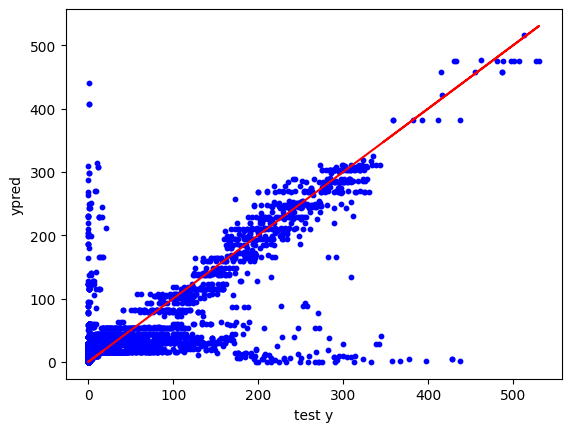

number of bottom  nodes:  236


In [18]:
plt.scatter(ytest,ypredT2,c='blue',s=10)
plt.xlabel('test y'); plt.ylabel('ypred')
plt.plot(y,y,c='red')
plt.show()
print("number of bottom  nodes: ",pd.Series(ypredT2).nunique())

## Random Forests  

Below I used random forests.  

Try n_estimators = 1000  

In [19]:
### sklearn model
from sklearn.ensemble import RandomForestRegressor

In [26]:
## fit rf on train, predict on val
# use 500 trees and 2 x's
rfm = RandomForestRegressor(n_estimators=1000,random_state=34)
#rfm = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=34)
rfm.fit(Xtrain,ytrain) # fit on train
## predict on val
ypredRF = rfm.predict(Xtest)

rmse from rf:  43.877


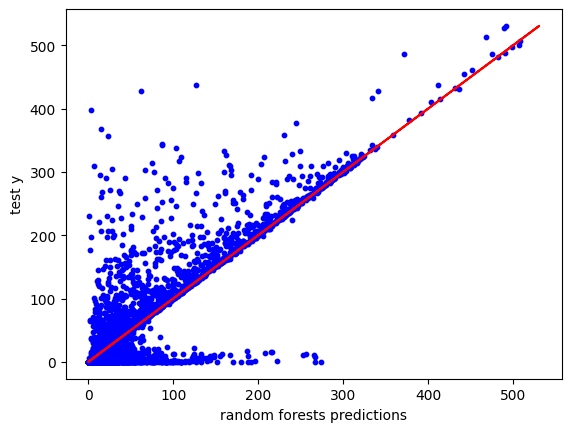

In [27]:
plt.scatter(ypredRF,ytest,c='blue',s=10)
plt.plot(ytest,ytest,c='red')
plt.xlabel('random forests predictions');plt.ylabel('test y')

print('rmse from rf: ',myrmse(ytest,ypredRF))

## Boosting  

Below are boosting results.  

Try n_estimators = 10000.

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

### try boosting## plot boosting prediction on val
gbm = GradientBoostingRegressor(learning_rate=.05,n_estimators=10000,max_depth=2,random_state=34)
gbm.fit(Xtrain,ytrain)
ypredB = gbm.predict(Xtest)

boosting rmse: 54.672


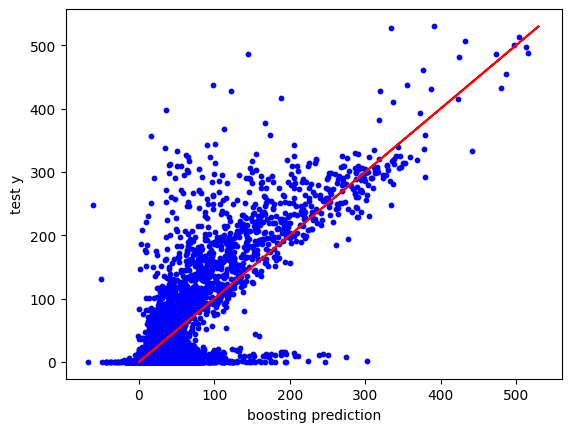

In [29]:
## plot boosting prediction on val
plt.scatter(ypredB,ytest,c='blue',s=10)
plt.plot(ytest,ytest,c='red')
plt.xlabel('boosting prediction');plt.ylabel('test y')

print(f'boosting rmse: {myrmse(ypredB,ytest)}')

## Neural Networks  

Below I used pytorch fit a neural net model.  

I did 5000 epochs.

In [30]:
### pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [33]:
##################################################
## scale both x and y, in principle you don't have to scale y
sc = StandardScaler()
xtr = sc.fit_transform(Xtrain)
xte = sc.transform(Xtest)

scy = StandardScaler()
ytr = scy.fit_transform(ytrain.reshape(-1,1))
yte = scy.transform(ytest.reshape(-1,1))

print(xtr.shape)
print(ytr.shape)
print(xte.shape)
print(yte.shape)

(15895, 9)
(15895, 1)
(3974, 9)
(3974, 1)


torch.Size([15895, 9])
torch.float32
torch.Size([15895, 1])
torch.float32
torch.float32


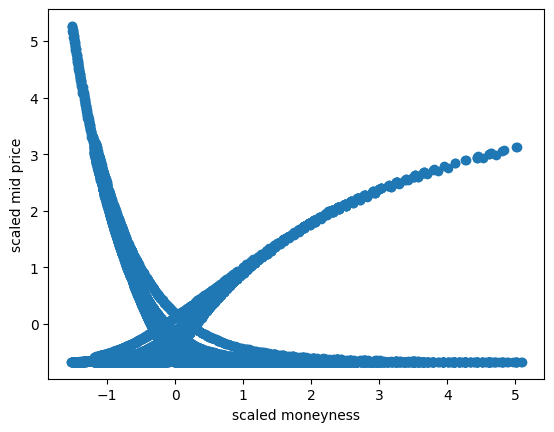

In [34]:
##################################################
## move to Tensors

xtr = xtr.astype('float32')
xxtr = torch.from_numpy(xtr)
ytr = ytr.astype('float32')
yytr = torch.from_numpy(ytr)

xte = xte.astype('float32')
xxte = torch.from_numpy(xte)
yte = yte.astype('float32')
yyte = torch.from_numpy(yte)

plt.scatter(xxtr[:,0],yytr)
plt.xlabel('scaled moneyness'); plt.ylabel('scaled mid price')

print(xxtr.shape)
print(xxtr.dtype)
print(yytr.shape)
print(yytr.dtype)
print(yyte.dtype)

In [35]:
##################################################
## Dataset

class DF(Dataset):
   def __init__(self,x,y,transform=None, target_transform=None):
      self.x = x
      self.y = y
      self.transform = transform
      self.target_transform = target_transform

   def __len__(self):
      return len(self.y)

   def __getitem__(self,idx):
      return self.x[idx], self.y[idx]


tDF = DF(xxtr,yytr)

In [36]:
##################################################
## DataLoader
tdl = DataLoader(tDF,batch_size=50,shuffle=True)

In [40]:
##################################################
## model

class SLNN(nn.Module):
   def __init__(self,nunits=5):
      super(SLNN, self).__init__()
      self.SSM = nn.Sequential(
         nn.Linear(9,nunits),
         nn.ReLU(),
         nn.Linear(nunits,1))
   def forward(self,x):
      yhat = self.SSM(x)
      return yhat

nunits= 50
model = SLNN(nunits)

## see model
print(model)

SLNN(
  (SSM): Sequential(
    (0): Linear(in_features=9, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [41]:
##################################################
### do it
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.x),dataloader.dataset.y).item()



learning_rate = .05
l2par = .0

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = l2par)

In [42]:
epochs = 5000
lv = np.zeros((epochs,))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lv[t] = train_loop(tdl, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

Text(0.5, 0, 'epoch')

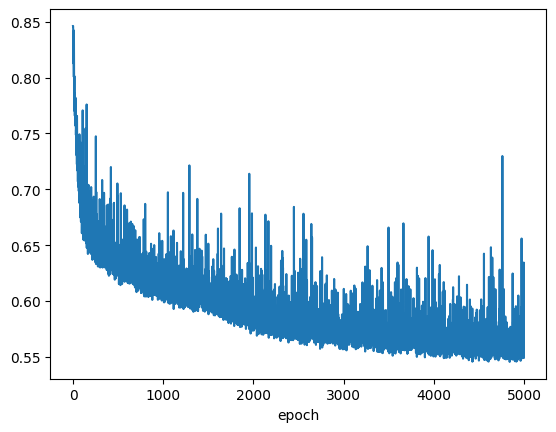

In [43]:
## plot loss over epochs
plt.plot(np.sqrt(lv))
plt.xlabel('epoch')

In [44]:
### out of sample
ypredN = model(xxte).detach().numpy()
ypredN = ypredN.astype('float64')
ypredN = scy.inverse_transform(ypredN)
ypredN = ypredN.flatten()
print(type(ypredN))
print(ypredN.shape)
print(ypredN.dtype)

<class 'numpy.ndarray'>
(3974,)
float64


neural net rmse: 49.68


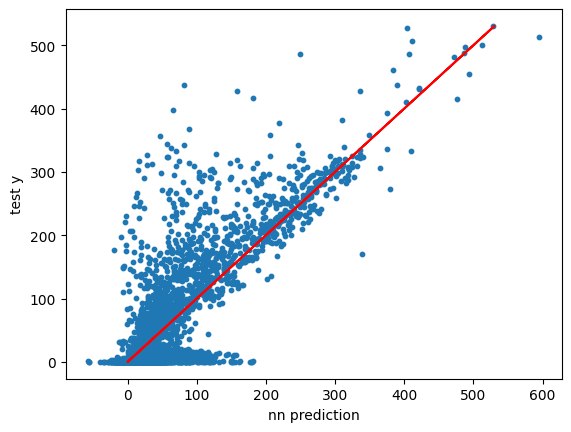

In [45]:
plt.scatter(ypredN,ytest,s=10)
plt.plot(ytest,ytest,c='red')
plt.xlabel('nn prediction'); plt.ylabel('test y')

print(f'neural net rmse: {myrmse(ypredN,ytest)}')

## Compare  

Let's compare the results from a single tree, random forests, boosting, and neural nets.  


In [46]:
## compare boosting to rf
ypredDF = pd.DataFrame({'ytest':ytest,'ypredT2':ypredT2,'ypredRF':ypredRF,'ypredB':ypredB,'ypredN':ypredN})
print(ypredDF.corr())


print('\n\nrmse: tree, rf, gb, nn:', myrmse(ypredT2,ytest),myrmse(ytest,ypredRF),myrmse(ytest,ypredB),myrmse(ytest,ypredN))

            ytest   ypredT2   ypredRF    ypredB    ypredN
ytest    1.000000  0.799991  0.870492  0.789515  0.831305
ypredT2  0.799991  1.000000  0.916175  0.834666  0.831218
ypredRF  0.870492  0.916175  1.000000  0.912753  0.914145
ypredB   0.789515  0.834666  0.912753  1.000000  0.912735
ypredN   0.831305  0.831218  0.914145  0.912735  1.000000


rmse: tree, rf, gb, nn: 54.25 43.877 54.672 49.68


In [47]:
import seaborn as sns

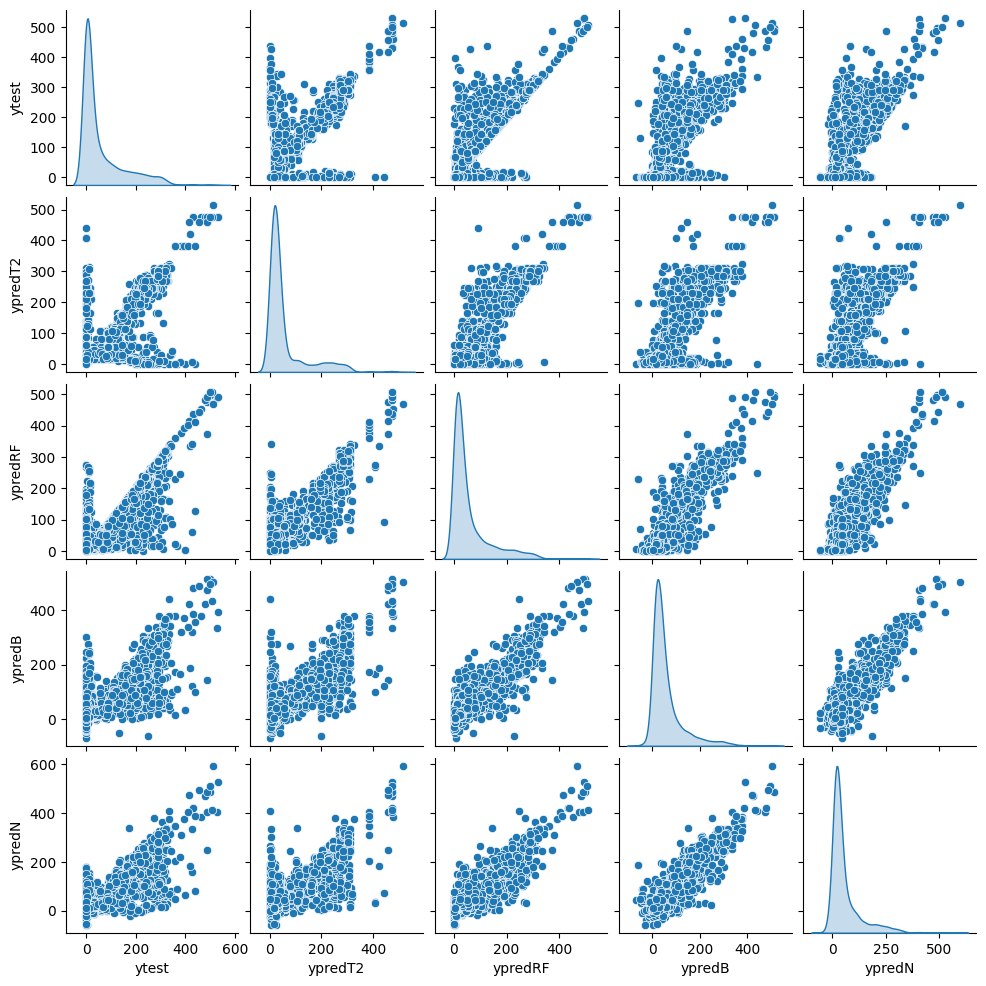

In [48]:
sns.pairplot(ypredDF,diag_kind='kde',height=2)